# Mod 3 Final Project

by: Jeremy Owens, Georgina Sampson

In [103]:
#importing libraries to utilize in experiment
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import time
import copy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
%matplotlib inline

In [2]:
crime_data = pd.read_csv('denver_data/crime_short.csv')
dispensary_data = pd.read_csv('denver_data/marijuana_active_business_licenses.csv')

In [3]:
print(len(crime_data))
crime_data.head()

450000


,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [4]:
crime_data.columns = [x.lower() for x in crime_data.columns]

In [5]:
crime_data = crime_data[crime_data.is_crime == 1]

In [6]:
crime_data['year'] = crime_data.reported_date.apply(lambda date: int(date.split()[0][-4:]))

In [7]:
offense_type_ids = list(crime_data.groupby('offense_type_id').count().index)

In [8]:
violent_list = [off for off in offense_type_ids if 'assault' in off] + \
                    [off for off in offense_type_ids if 'homicide' in off] + \
                    [off for off in offense_type_ids if 'robbery' in off] + \
                    [off for off in offense_type_ids if 'sex-aslt' in off] + \
                    ['agg-aslt-police-weapon', 'aslt-agg-police-gun']
violent_list.pop(violent_list.index('traf-vehicular-assault'))

drug_list = [off for off in offense_type_ids if 'drug' in off]

In [9]:
def gen_offense_type(offense):
    if offense in violent_list:
        return 'violent'
    elif offense in drug_list:
        return 'drug'
    else:
        return 'other'

In [10]:
crime_data['gen_offense_type'] = crime_data.offense_type_id.apply(lambda offense: gen_offense_type(offense))

In [11]:
crime_data_short = crime_data.drop(['offense_code', 'offense_id', 'offense_code_extension', 'offense_type_id', 
                                    'offense_category_id', 'first_occurrence_date', 'last_occurrence_date', 
                                    'incident_address', 'geo_x', 'geo_y', 'geo_lon', 'geo_lat', 'district_id', 
                                    'precinct_id', 'is_crime', 'is_traffic', 'reported_date'], 
                                    axis=1)
crime_data_short.sample(10)

,incident_id,neighborhood_id,year,gen_offense_type
206440,2017403575,cbd,2017,other
328126,2015605440,five-points,2015,drug
265574,2019412962,union-station,2019,other
93072,2014631953,sunnyside,2014,other
384769,201674715,overland,2016,other
198450,2016798287,congress-park,2016,other
392953,2016526321,cheesman-park,2016,other
58365,2019130045,northeast-park-hill,2019,other
347154,2017536391,hampden-south,2017,other
355366,2017358030,barnum-west,2017,other


In [14]:
crime_data_grouped = crime_data_short.groupby(['neighborhood_id', 'year', 'gen_offense_type']).count()
crime_data_grouped = crime_data_grouped.reset_index()
crime_data_grouped

,neighborhood_id,year,gen_offense_type,incident_id
0,athmar-park,2014,drug,77
1,athmar-park,2014,other,957
2,athmar-park,2014,violent,91
3,athmar-park,2015,drug,82
4,athmar-park,2015,other,923
5,athmar-park,2015,violent,111
6,athmar-park,2016,drug,72
7,athmar-park,2016,other,998
8,athmar-park,2016,violent,97
9,athmar-park,2017,drug,64


In [15]:
dispensary_data.columns = [x.lower().replace(' ', '_') for x in dispensary_data.columns]
dispensary_data = dispensary_data[['business_file_number', 'license_type', 'facility_zip_code']]
dispensary_data

,business_file_number,license_type,facility_zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204.0
1,2018-BFN-0000285,Retail Marij Opt. Prem. Cultiv,80216.0
2,2018-BFN-0000461,Retail Marijuana Store,80239.0
3,2014-BFN-0004431,Med Marijuana Opt Prem Cultiv,80216.0
4,2014-BFN-0004811,Retail Marijuana Store,80216.0
5,2013-BFN-1065013,Med Marijuana Opt Prem Cultiv,80216.0
6,2013-BFN-1066526,Med Marijuana Inf Prod Manuf,80216.0
7,2013-BFN-1066097,Med Marijuana Inf Prod Manuf,NaN
8,2013-BFN-1069615,Retail Marijuana Store,80210.0
9,2013-BFN-1069055,Retail Marijuana Store,80202.0


In [17]:
dispensary_data.dropna(inplace=True)
dispensary_data['zip_code'] = dispensary_data.facility_zip_code.astype('int64')
dispensary_data.drop('facility_zip_code', inplace=True, axis=1)

In [18]:
stores_data = dispensary_data[dispensary_data.license_type.isin(['Retail Marijuana Store', 
                                                                 'Medical Marijuana Center'])]
print(len(stores_data))
stores_data.head(10)

345


,business_file_number,license_type,zip_code
0,2016-BFN-0007402,Retail Marijuana Store,80204
2,2018-BFN-0000461,Retail Marijuana Store,80239
4,2014-BFN-0004811,Retail Marijuana Store,80216
8,2013-BFN-1069615,Retail Marijuana Store,80210
9,2013-BFN-1069055,Retail Marijuana Store,80202
11,2016-BFN-0004809,Retail Marijuana Store,80223
12,2015-BFN-0002256,Medical Marijuana Center,80211
19,2018-BFN-0007446,Retail Marijuana Store,80205
20,2010-BFN-1045700,Medical Marijuana Center,80209
21,2010-BFN-1048389,Medical Marijuana Center,80216


In [19]:
store_count = stores_data.groupby('zip_code')['business_file_number'].count()
store_count

zip_code
80123     2
80127     2
80202    13
80203    18
80204    25
80205    22
80206     5
80207     6
80209     8
80210    35
80211    20
80212     6
80214     2
80216    45
80218     6
80219    21
80220    15
80222     9
80223    39
80224    10
80231     4
80232     4
80236     2
80237     2
80239    20
80247     2
80249     2
Name: business_file_number, dtype: int64

In [20]:
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html')
soup = BeautifulSoup(html_page.content, 'html.parser')

In [21]:
zip_code_list = []
zip_codes = soup.find(class_="zip-codes").findAll('a', recursive=False)
for tag in zip_codes:
    zip_code_list.append(int(tag.text))
zip_code_list[:5]

[80012, 80014, 80110, 80111, 80123]

In [23]:
zip_neighbor_dict = {}
for zip_code in zip_code_list:
    html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(zip_code))
    soup = BeautifulSoup(html_page.content, 'html.parser')
    neighborhoods = []
    for a in soup.find_all('a'):
        if 'neighborhood' in a.text:
            if a.text.split()[-1] == 'neighborhood':
                if len(a.text.split()) < 6:
                    if 'Central Business District' in a.text:
                        neighborhood = 'cbd'
                    elif '(' in a.text:
                        neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                    else:
                        neighborhood = '-'.join(a.text.split()[:-1]).lower()
                    neighborhoods.append(neighborhood)
    zip_neighbor_dict.update({zip_code: neighborhoods})
    time.sleep(0.5)
    
zip_neighbor_dict

{80012: ['aurora-district', 'city-center'],
 80014: ['cherry-creek-district', 'kennedy'],
 80110: ['college-view',
  'fort-logan',
  'harvey-park-south',
  'overland',
  'south-platte',
  'southwest',
  'university',
  'wellshire'],
 80111: ['kennedy'],
 80123: ['fort-logan', 'marston', 'southwest'],
 80202: ['cbd',
  'central-platte-valley',
  'cbd',
  'five-points',
  'highland',
  'lower-downtown',
  'north-capitol-hill',
  'union-station'],
 80203: ['alamo-placita',
  'capitol-hill',
  'civic-center',
  'five-points',
  'golden-triangle',
  'north-capitol-hill',
  'speer',
  'uptown'],
 80204: ['auraria',
  'baker',
  'barnum',
  'barnum-west',
  'cbd',
  'civic-center',
  'colfax',
  'cbd',
  'golden-triangle',
  'lincoln-park',
  'lower-downtown',
  'sheridan-boulevard',
  'sloan-lake',
  'southwest',
  'sun-valley',
  'union-station',
  'valverde',
  'villa-park'],
 80205: ['ballpark',
  'city-park',
  'city-park-west',
  'clayton',
  'cole',
  'curtis-park',
  'five-points',
  

In [24]:
crime_neighborhoods = list(crime_data_short.neighborhood_id.unique())
sorted(crime_neighborhoods)

['athmar-park',
 'auraria',
 'baker',
 'barnum',
 'barnum-west',
 'bear-valley',
 'belcaro',
 'berkeley',
 'capitol-hill',
 'cbd',
 'chaffee-park',
 'cheesman-park',
 'cherry-creek',
 'city-park',
 'city-park-west',
 'civic-center',
 'clayton',
 'cole',
 'college-view-south-platte',
 'congress-park',
 'cory-merrill',
 'country-club',
 'dia',
 'east-colfax',
 'elyria-swansea',
 'five-points',
 'fort-logan',
 'gateway-green-valley-ranch',
 'globeville',
 'goldsmith',
 'hale',
 'hampden',
 'hampden-south',
 'harvey-park',
 'harvey-park-south',
 'highland',
 'hilltop',
 'indian-creek',
 'jefferson-park',
 'kennedy',
 'lincoln-park',
 'lowry-field',
 'mar-lee',
 'marston',
 'montbello',
 'montclair',
 'north-capitol-hill',
 'north-park-hill',
 'northeast-park-hill',
 'overland',
 'platt-park',
 'regis',
 'rosedale',
 'ruby-hill',
 'skyland',
 'sloan-lake',
 'south-park-hill',
 'southmoor-park',
 'speer',
 'stapleton',
 'sun-valley',
 'sunnyside',
 'union-station',
 'university',
 'universit

In [25]:
zip_neighbor_dict_mod = copy.deepcopy(zip_neighbor_dict)

In [26]:
for key, values in zip_neighbor_dict_mod.items():
    counter = 0
    list_len = len(values)
    if list_len == 0:
        continue
    else:
        while counter < list_len:
            if values[counter] not in crime_neighborhoods:
                del values[counter]
                list_len -= 1
            else:
                counter += 1
for key, values in zip_neighbor_dict_mod.items():
    values = list(set(values))
    zip_neighbor_dict_mod.update({key: values})
zip_neighbor_dict_mod

{80012: [],
 80014: ['kennedy'],
 80110: ['wellshire',
  'harvey-park-south',
  'university',
  'overland',
  'fort-logan'],
 80111: ['kennedy'],
 80123: ['marston', 'fort-logan'],
 80202: ['union-station',
  'cbd',
  'highland',
  'north-capitol-hill',
  'five-points'],
 80203: ['speer',
  'north-capitol-hill',
  'five-points',
  'civic-center',
  'capitol-hill'],
 80204: ['union-station',
  'villa-park',
  'sloan-lake',
  'cbd',
  'baker',
  'barnum',
  'sun-valley',
  'lincoln-park',
  'auraria',
  'civic-center',
  'barnum-west',
  'valverde'],
 80205: ['city-park-west',
  'whittier',
  'clayton',
  'city-park',
  'north-capitol-hill',
  'five-points',
  'cole',
  'skyland'],
 80206: ['city-park-west',
  'cherry-creek',
  'cheesman-park',
  'city-park',
  'country-club',
  'congress-park'],
 80207: ['north-park-hill',
  'south-park-hill',
  'northeast-park-hill',
  'stapleton'],
 80209: ['washington-park',
  'cherry-creek',
  'country-club',
  'speer',
  'belcaro',
  'washington-pa

In [27]:
neighborhoods_df = pd.DataFrame.from_dict(zip_neighbor_dict_mod, orient='index')
neighborhoods_df.dropna(how='all', inplace=True)
neighborhoods_df = neighborhoods_df.reset_index()
neighborhoods_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11
0,80014,kennedy,None,None,None,None,None,None,None,None,None,None,None
1,80110,wellshire,harvey-park-south,university,overland,fort-logan,None,None,None,None,None,None,None
2,80111,kennedy,None,None,None,None,None,None,None,None,None,None,None
3,80123,marston,fort-logan,None,None,None,None,None,None,None,None,None,None
4,80202,union-station,cbd,highland,north-capitol-hill,five-points,None,None,None,None,None,None,None


In [28]:
def calc_crime(zip_code, year, crime_type):
    sum_of_crime = 0
    if crime_type == 'violent':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'violent')]['incident_id'].sum()
    elif crime_type == 'drug':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year) &
                                               (crime_data_grouped.gen_offense_type == 'drug')]['incident_id'].sum()
    elif crime_type == 'all':
        for neighborhood in zip_neighbor_dict_mod[zip_code]:
            sum_of_crime += crime_data_grouped[(crime_data_grouped.neighborhood_id == neighborhood) & 
                                               (crime_data_grouped.year == year)]['incident_id'].sum()
            
    return int(round(sum_of_crime / len(zip_neighbor_dict_mod[zip_code]), 0))


In [29]:
neighborhoods_df['2014_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'all'))
neighborhoods_df['2014_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'violent'))
neighborhoods_df['2014_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2014, 'drug'))

neighborhoods_df['2017_all_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'all'))
neighborhoods_df['2017_violent_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'violent'))
neighborhoods_df['2017_drug_crime'] = neighborhoods_df['index'].apply(lambda index: calc_crime(index, 2017, 'drug'))


In [30]:
neighborhoods_df = neighborhoods_df.drop(range(12), axis=1)
neighborhoods_df.rename({'index': 'zip_code'}, axis=1, inplace=True)
neighborhoods_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime
0,80014,250,41,3,335,51,9
1,80110,389,45,19,388,38,20
2,80111,250,41,3,335,51,9
3,80123,296,30,4,417,53,4
4,80202,2012,246,205,2078,275,181


In [31]:
final_df = neighborhoods_df.join(store_count, on='zip_code')
final_df.fillna(0, inplace=True)
final_df.rename({'business_file_number': 'dispensary_count'}, axis=1, inplace=True)
final_df = final_df.astype({'dispensary_count': 'int64'})
final_df.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count
0,80014,250,41,3,335,51,9,0
1,80110,389,45,19,388,38,20,0
2,80111,250,41,3,335,51,9,0
3,80123,296,30,4,417,53,4,2
4,80202,2012,246,205,2078,275,181,13
5,80203,1721,232,156,2085,273,250,18
6,80204,1102,130,92,1086,138,81,25
7,80205,930,122,80,1024,141,91,22
8,80206,550,53,17,555,57,15,5
9,80207,993,88,40,1036,97,46,6


## Scraping for median income and population per zip-code

In [32]:
html_page = requests.get('http://www.city-data.com/zipmaps/Denver-Colorado.html') #Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing

In [36]:
def medianIncomePerYear(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        median_household_income = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated median household income in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                median_household_income = int(income_string)
        yield {zipCode: median_household_income}
medianIncomePerYear2016 = [zipCode for zipCode in medianIncomePerYear(2016, soup)]
medianIncomePerYear2016_fulldict = {}
for zip_code_income in medianIncomePerYear2016:
    for key, val in zip_code_income.items():
        if val == 0:
            continue
        else:
            medianIncomePerYear2016_fulldict.update({key: val})
medianIncomePerYear2016_fulldict

{80012: 47637,
 80014: 54779,
 80110: 50448,
 80111: 101311,
 80123: 77226,
 80202: 73743,
 80203: 49252,
 80204: 36586,
 80205: 60235,
 80206: 67196,
 80207: 67419,
 80209: 89207,
 80210: 80986,
 80211: 66879,
 80212: 67427,
 80214: 39190,
 80216: 45290,
 80218: 55713,
 80219: 43188,
 80220: 71270,
 80221: 52867,
 80222: 52772,
 80223: 45186,
 80224: 53003,
 80226: 57716,
 80227: 64022,
 80230: 80495,
 80231: 53219,
 80232: 65087,
 80235: 57765,
 80236: 53593,
 80237: 69327,
 80239: 52513,
 80246: 47818,
 80249: 73623}

In [37]:
def Population(year, html):
    for zipStatistics in html.findAll('div', class_="data-block"):
        # <strong>Zip code 80014 statistics:</strong>
        strong = zipStatistics.find('strong').text
        zipCode = int(re.match(r"(Zip code )(\d{5})( statistics:)", strong).groups()[1])
        pop = 0
        for bold_tag in zipStatistics.findAll('b'):
            if f"Estimated zip code population in {year}:" in bold_tag.text:
                income_string = bold_tag.nextSibling
                income_string = income_string.strip()
                income_string = re.sub("\$", "", income_string)
                income_string = re.sub(",","", income_string)
                pop = int(income_string)
        yield {zipCode: pop}
pop2016 = [zipCode for zipCode in Population(2016, soup)]
pop2016_fulldict = {}
for zip_code_pop in pop2016:
    for key, val in zip_code_pop.items():
        if val == 0:
            continue
        else:
            pop2016_fulldict.update({key: val})
pop2016_fulldict

{80012: 51510,
 80014: 39054,
 80110: 22106,
 80111: 32382,
 80123: 46458,
 80202: 12824,
 80203: 20809,
 80204: 32769,
 80205: 33012,
 80206: 23852,
 80207: 25706,
 80209: 25608,
 80210: 36503,
 80211: 33735,
 80212: 19700,
 80214: 25614,
 80216: 12640,
 80218: 19055,
 80219: 68307,
 80220: 36227,
 80221: 41064,
 80222: 21577,
 80223: 19956,
 80224: 19338,
 80226: 32775,
 80227: 35484,
 80230: 8612,
 80231: 36425,
 80232: 22719,
 80235: 8015,
 80236: 18749,
 80237: 20158,
 80239: 46496,
 80246: 13474,
 80249: 29440}

In [38]:
final_df_income = final_df.join(pd.DataFrame.from_dict(medianIncomePerYear2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income = final_df_income.rename({0: 'median_income'}, axis=1)

final_df_income_pop = final_df_income.join(pd.DataFrame.from_dict(pop2016_fulldict, orient='index'), 
                                on='zip_code')
final_df_income_pop = final_df_income_pop.rename({0: 'population'}, axis=1)
final_df_income_pop.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population
0,80014,250,41,3,335,51,9,0,54779,39054
1,80110,389,45,19,388,38,20,0,50448,22106
2,80111,250,41,3,335,51,9,0,101311,32382
3,80123,296,30,4,417,53,4,2,77226,46458
4,80202,2012,246,205,2078,275,181,13,73743,12824
5,80203,1721,232,156,2085,273,250,18,49252,20809
6,80204,1102,130,92,1086,138,81,25,36586,32769
7,80205,930,122,80,1024,141,91,22,60235,33012
8,80206,550,53,17,555,57,15,5,67196,23852
9,80207,993,88,40,1036,97,46,6,67419,25706


In [66]:
def econ_status(income):
    if income <= final_df_income_pop.median_income.quantile([0.25]).sum():
        return 'low'
    elif income >= final_df_income_pop.median_income.quantile([0.75]).sum():
        return 'high'
    else:
        return 'middle'

In [67]:
final_df_income_pop['store_per_1Kpeople'] = round(final_df_income_pop.dispensary_count / 
                                                  (final_df_income_pop.population / 1000), 4)
final_df_income_pop['neighborhood_econ_status'] = final_df_income_pop.median_income.apply(lambda income:
                                                                                                econ_status(income))
final_df_income_pop.head()

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high
5,80203,1721,232,156,2085,273,250,18,49252,20809,0.8650,low
6,80204,1102,130,92,1086,138,81,25,36586,32769,0.7629,low
7,80205,930,122,80,1024,141,91,22,60235,33012,0.6664,middle
8,80206,550,53,17,555,57,15,5,67196,23852,0.2096,middle
9,80207,993,88,40,1036,97,46,6,67419,25706,0.2334,middle


## Putting our data into a SQL database

In [80]:
conn = sqlite3.connect("database.sqlite")
c = conn.cursor()

In [81]:
final_df_income_pop.set_index('zip_code').to_sql('zip_code_statistics', conn, if_exists='replace')

In [82]:
pd.read_sql_query('''SELECT * FROM zip_code_statistics LIMIT 5''', conn)

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high


In [83]:
c.close()
conn.close()

In [109]:
final_df_income_pop.drop('2017_violent_log', axis=1, inplace=True)
final_df_income_pop.drop('2017_drug_log', axis=1, inplace=True)

In [110]:
final_df_income_pop['violent_log_2017'] = np.log(final_df_income_pop['2017_violent_crime'])
final_df_income_pop['drug_log_2017'] = np.log(final_df_income_pop['2017_drug_crime'])
final_df_income_pop

,zip_code,2014_all_crime,2014_violent_crime,2014_drug_crime,2017_all_crime,2017_violent_crime,2017_drug_crime,dispensary_count,median_income,population,store_per_1Kpeople,neighborhood_econ_status,violent_log_2017,drug_log_2017
0,80014,250,41,3,335,51,9,0,54779,39054,0.0000,middle,3.931826,2.197225
1,80110,389,45,19,388,38,20,0,50448,22106,0.0000,low,3.637586,2.995732
2,80111,250,41,3,335,51,9,0,101311,32382,0.0000,high,3.931826,2.197225
3,80123,296,30,4,417,53,4,2,77226,46458,0.0430,high,3.970292,1.386294
4,80202,2012,246,205,2078,275,181,13,73743,12824,1.0137,high,5.616771,5.198497
5,80203,1721,232,156,2085,273,250,18,49252,20809,0.8650,low,5.609472,5.521461
6,80204,1102,130,92,1086,138,81,25,36586,32769,0.7629,low,4.927254,4.394449
7,80205,930,122,80,1024,141,91,22,60235,33012,0.6664,middle,4.948760,4.510860
8,80206,550,53,17,555,57,15,5,67196,23852,0.2096,middle,4.043051,2.708050
9,80207,993,88,40,1036,97,46,6,67419,25706,0.2334,middle,4.574711,3.828641


In [93]:
def make_formula(dv, iv):
    string = dv + '~' + str(iv[0])
    if len(iv) > 1:
        for i in range(1, len(iv)):
            string += '+' + str(iv[i])
    return string

In [114]:
formula = make_formula('violent_log_2017', ['store_per_1Kpeople'])

model = smf.ols(formula=formula, data=final_df_income_pop).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       violent_log_2017   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     5.538
Date:                Mon, 15 Jul 2019   Prob (F-statistic):             0.0261
Time:                        20:50:56   Log-Likelihood:                -25.770
No. Observations:                  29   AIC:                             55.54
Df Residuals:                      27   BIC:                             58.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1655      0.137     30.389      0.000       3.884       4.447
store_per_1Kpeople     0.3713      0.158      2.353      0.026       0.048       0.695
==============================================================================
Omnibus:                        0.624   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.075
Skew:                           0.080   Prob(JB):                        0.963
Kurtosis:                       3.190   Cond. No.                         1.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
violent_dispensary_2017 = final_df_income_pop.sort_values('violent_log_2017')[['violent_log_2017', 
                                                                               'store_per_1Kpeople']].reset_index()
violent_dispensary_2017.drop('index', axis=1, inplace=True)
violent_dispensary_2017

,violent_log_2017,store_per_1Kpeople
0,3.091042,0.9588
1,3.258097,0.3124
2,3.583519,0.0000
3,3.637586,0.0000
4,3.713572,0.3046
5,3.931826,0.0000
6,3.931826,0.0000
7,3.951244,0.1067
8,3.970292,0.0430
9,4.043051,0.2096


<function matplotlib.pyplot.show(*args, **kw)>

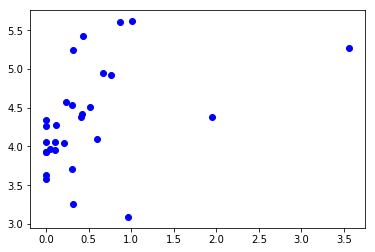

In [146]:
plt.scatter(violent_dispensary_2017.store_per_1Kpeople, violent_dispensary_2017.violent_log_2017, c='blue')
plt.plot()
plt.show

In [115]:
formula = make_formula('drug_log_2017', ['store_per_1Kpeople'])

model = smf.ols(formula=formula, data=final_df_income_pop).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          drug_log_2017   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     9.831
Date:                Mon, 15 Jul 2019   Prob (F-statistic):            0.00411
Time:                        20:53:37   Log-Likelihood:                -36.801
No. Observations:                  29   AIC:                             77.60
Df Residuals:                      27   BIC:                             80.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.1348      0.201     15.634      0.000       2.723       3.546
store_per_1Kpeople     0.7238      0.231      3.136      0.004       0.250       1.197
==============================================================================
Omnibus:                        0.623   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.716
Skew:                           0.270   Prob(JB):                        0.699
Kurtosis:                       2.452   Cond. No.                         1.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Working Zone

In [ ]:
print(len(crime_data))
crime_data.isna().sum()

In [ ]:
print(len(crime_data))
crime_data.sample(10)

In [ ]:
html_page = requests.get('http://www.city-data.com/zips/{}.html'.format(80202))
soup = BeautifulSoup(html_page.content, 'html.parser')
neighborhoods = []
for a in soup.find_all('a'):
    if 'neighborhood' in a.text:
        if a.text.split()[-1] == 'neighborhood':
            if len(a.text.split()) < 6:
                if 'Central Business District' in a.text:
                    neighborhood = 'cbd'
                elif '(' in a.text:
                    neighborhood = '-'.join(a.text[:(a.text.index('(') - 1)].split()).lower()
                else:
                    neighborhood = '-'.join(a.text.split()[:-1]).lower()
                neighborhoods.append(neighborhood)
neighborhoods

In [ ]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

In [ ]:
violent_data = crime_data[crime_data['gen_offense_type'] == 'violent']
drug_data = crime_data[crime_data['gen_offense_type'] == 'drug']

In [16]:
neighborhoods_to_analyze = {}
for key, val in initial_neighborhood_counts.items():
    if val > 1:
        like_neighborhoods = []
        for key2, val2 in zip_neighbor_dict_mod.items():
             if key in val2:
                    like_neighborhoods.append(key2)
        neighborhoods_to_analyze.update({key: like_neighborhoods})
neighborhoods_to_analyze

NameError: name 'initial_neighborhood_counts' is not defined

In [ ]:
offense_data.head(10)

In [ ]:
offense_data.groupby('OFFENSE_CATEGORY_ID')['OFFENSE_CODE'].count()

In [ ]:
print(len(dispensary_data))
dispensary_data.sample(10)

In [ ]:
dispensary_data.groupby('Trade Name').count()

In [ ]:
dispensary_data[dispensary_data['Trade Name'] == '1136 YUMA']